In [1]:
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
import matplotlib.colors
print matplotlib.__version__
import matplotlib.style
import scipy.interpolate
import osgeo.osr

import skimage.draw
import skimage.filter
import skimage.morphology
matplotlib.style.use('ggplot')

%matplotlib inline

1.4.3


/Users/baart_f/.virtualenvs/main/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


In [2]:
# open the netCDF file with velocity fields over time and depth
filename = '/Volumes/OSX/dws_200m_v6_2009_05/trim-dws_200m_v6_2009_05.nc'
ds = netCDF4.Dataset(filename)

In [99]:
# plot the velocity fields
# in m,n coordinates
k = 0
N_angle = matplotlib.colors.Normalize(-np.pi, np.pi, clip=True)
N_norm = matplotlib.colors.Normalize(0, 1.0, clip=True)

for t in range(0, 60):
    u1 = ds.variables['U1'][t]
    v1 = ds.variables['V1'][t]
    kfu = ds.variables['KFU'][t]
    kfv = ds.variables['KFV'][t]
    mask = ~np.logical_or(kfu, kfv)
    angle = np.ma.masked_array(np.arctan2(v1[k], u1[k]), mask=mask).T
    norm = np.ma.masked_array(np.sqrt(v1[k] ** 2 +  u1[k]**2), mask=mask).T
    h = N_angle(angle)[...,np.newaxis]
    v = N_norm(norm)[...,np.newaxis] 
    s = np.ones_like(angle, dtype='float32')[...,np.newaxis]
    hsv = np.dstack([h, s, v])
    rgb = matplotlib.colors.hsv_to_rgb(hsv)
    rgba = np.dstack([rgb,  (~mask.T)[...,np.newaxis]*v.filled(0) ])
    plt.imsave('vel%04d.png' % (t,),  rgba[::-1,:,:])

In [4]:
xz = np.ma.masked_array(ds.variables['XZ'][:], mask=~np.logical_or(kfu, kfv))
yz = np.ma.masked_array(ds.variables['YZ'][:], mask=~np.logical_or(kfu, kfv))

In [5]:
# let's define the systems
src_srs = osgeo.osr.SpatialReference()
src_srs.ImportFromEPSG(4326)
dst_srs = osgeo.osr.SpatialReference()
dst_srs.ImportFromEPSG(900913)
wgs84 = osgeo.osr.SpatialReference()
wgs84.ImportFromEPSG(4326)
utm = osgeo.osr.SpatialReference()
utm.ImportFromEPSG(32631)

# and the translations between them
src2wgs84 = osgeo.osr.CoordinateTransformation(src_srs, wgs84)
dst2wgs84 = osgeo.osr.CoordinateTransformation(dst_srs, wgs84)
utm2wgs84 = osgeo.osr.CoordinateTransformation(utm, wgs84)
wgs842utm = osgeo.osr.CoordinateTransformation(wgs84, utm)
utm2dst = osgeo.osr.CoordinateTransformation(utm, dst_srs)
src2utm = osgeo.osr.CoordinateTransformation(src_srs, utm)

src2dst = osgeo.osr.CoordinateTransformation(src_srs, dst_srs)

In [6]:
coords = np.array(src2utm.TransformPoints(np.c_[xz.ravel(), yz.ravel()]))
x, y = np.ma.masked_array(coords[:,0].reshape(xz.shape), mask=mask), np.ma.masked_array(coords[:,1].reshape(yz.shape), mask=mask)


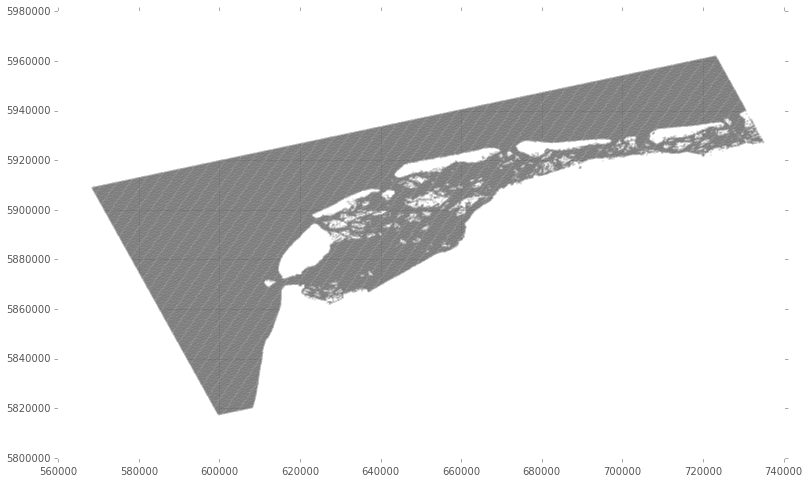

In [7]:
fig, ax = plt.subplots(figsize=(13,8))
ax.plot(x.ravel(), y.ravel(), 'k.', alpha=0.3, markersize = 1 )

In [8]:
Xx, Xy = np.gradient(x)
Yx, Yy = np.gradient(y)

ll = np.c_[(x - 0.5*Xx + 0.5*Yx)[~mask], (y - 0.5*Yy + 0.5*Xy)[~mask]]
lr = np.c_[(x + 0.5*Xx + 0.5*Yx)[~mask], (y - 0.5*Yy - 0.5*Xy)[~mask]]
ul = np.c_[(x - 0.5*Xx - 0.5*Yx)[~mask], (y + 0.5*Yy + 0.5*Xy)[~mask]]
ur = np.c_[(x + 0.5*Xx - 0.5*Yx)[~mask], (y + 0.5*Yy - 0.5*Xy)[~mask]]

verts = np.hstack(
    [ll[:,np.newaxis,:], 
     lr[:,np.newaxis,:], 
     ur[:,np.newaxis,:], 
     ul[:,np.newaxis,:]]
)



In [9]:
poly = matplotlib.collections.PolyCollection(
    np.hstack([ll[:,np.newaxis,:], lr[:,np.newaxis,:], ur[:,np.newaxis,:], ul[:,np.newaxis,:]]),
    edgecolors='none'
)

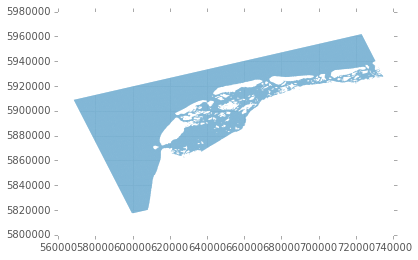

In [10]:
fig, ax = plt.subplots()
ax.add_collection(poly)
ax.autoscale()

In [11]:
# We want velocities in pixels/s in our target coordinate system

# We thus need to know how wide each pixel is in the  target system

# We also have to take into account that 1 meter in utm10n does not correspond to 
# 1 meter in web mercator. 
# The web mercator is not very accurate, it is not a conformal projection.

# One way to correct for this is to compute a correction factor for each point

points_gm = np.array(utm2dst.TransformPoints(np.c_[x.ravel(), y.ravel()]))[~mask.ravel()]
points_utm = np.array(np.c_[x.ravel(), y.ravel(), np.zeros_like(x.ravel())])[~mask.ravel()]

# compute the local distortion 
# how many meters is 1 meter in the projected system, given x,y
x_plus_half = np.array(utm2dst.TransformPoints(np.c_[x.ravel() + 0.5, y.ravel()]))
x_minus_half = np.array(utm2dst.TransformPoints(np.c_[x.ravel() - 0.5, y.ravel()]))
y_plus_half = np.array(utm2dst.TransformPoints(np.c_[x.ravel(), y.ravel() + 0.5]))
y_minus_half = np.array(utm2dst.TransformPoints(np.c_[x.ravel(), y.ravel() - 0.5]))

# compute the deformation factor
x_distort = (x_plus_half - x_minus_half)[:,0]
y_distort = (y_plus_half - y_minus_half)[:,1]

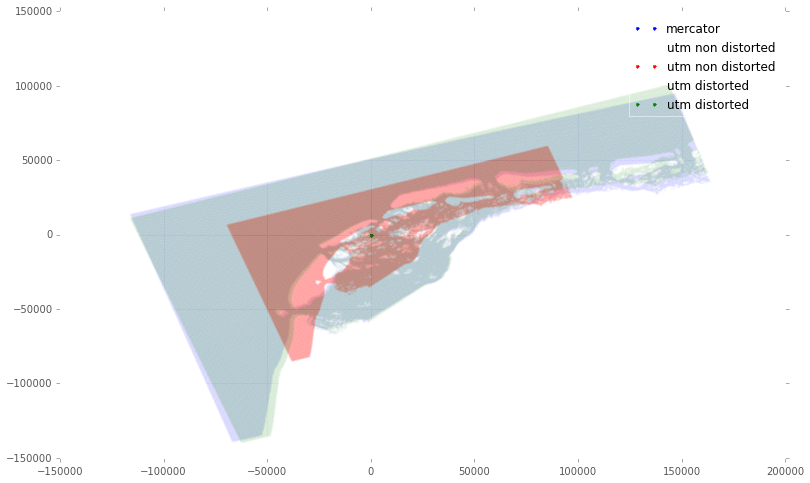

In [30]:
# check if these velocities match up, somewhat...
# See http://www.hydrometronics.com/downloads/Web%20Mercator%20-%20Non-Conformal,%20Non-Mercator%20(notes).pdf
# for details
fig, ax = plt.subplots(figsize=(13,8))
points_gm_central = (points_gm - points_gm.mean(axis=0))
points_utm_central = points_utm - points_utm.mean(axis=0)

ax.plot(points_gm_central[:,0], points_gm_central[:,1], 'b.', alpha=0.4, markersize=0.2)
ax.plot(0,0, 'b.', label='mercator')
ax.plot(points_utm_central[:,0] , points_utm_central[:,1] , 'r.', label='utm non distorted', alpha=0.4, markersize=0.2)
ax.plot(0,0, 'r.', label='utm non distorted')
ax.plot(points_utm_central[:,0] * x_distort[~mask.ravel()], points_utm_central[:,1] * y_distort[~mask.ravel()], 'g.', label='utm distorted', alpha=0.4, markersize=0.2)
ax.plot(0,0, 'g.', label='utm distorted')
ax.legend()

In [31]:
# create an interpolation function that gives us velocities at each point in the domain.
# in this case we use a triangulated interpolation, which isn't optimal, but ok for now

# Create an interpolation function to map the velocities in web mercator projection
F = scipy.interpolate.LinearNDInterpolator(
    points_gm[:,:2], 
    np.c_[
        u1[0].ravel()[~mask.ravel()] * x_distort[~mask.ravel()], 
        v1[0].ravel()[~mask.ravel()] * y_distort[~mask.ravel()]
    ]
)
F.fill_value = 0.0

In [32]:
# now create a map in google mercator
ll_gm = [F.points[:,0].min(), F.points[:,1].min()]
ur_gm = [F.points[:,0].max(), F.points[:,1].max()]

# we want a big map as the base layer. 
nx = 1024
ny = 1024

x = np.linspace(ll_gm[0], ur_gm[0], num=nx)
y = np.linspace(ll_gm[1], ur_gm[1], num=ny)

X, Y = np.meshgrid(x, y)

In [33]:
UV = F(X, Y)

ll_wgs84 = dst2wgs84.TransformPoint(x[0], y[0])
ur_wgs84 = dst2wgs84.TransformPoint(x[-1], y[-1])
# this is the bounding box that we need for adding the map
# should this be plus 1 cell?
ll_wgs84, ur_wgs84


((4.026927471160947, 52.498012542723586, 0.0),
 (6.538724422447244, 53.758518218850185, 0.0))

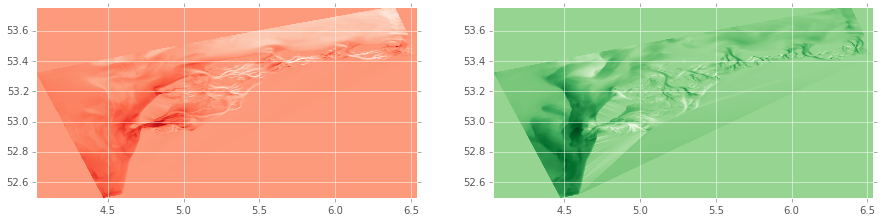

In [34]:
fig, axes = plt.subplots(1,2 , figsize=(15,8))
axes[0].imshow(UV[...,0], cmap='Reds', origin='lower', extent=[ll[0], ur[0], ll[1], ur[1] ])
axes[1].imshow(UV[...,1], cmap='Greens', origin='lower', extent=[ll[0], ur[0], ll[1], ur[1]])


In [43]:
verts_gm = np.array(
    utm2dst.TransformPoints(
        np.c_[
            verts[...,0].ravel(), 
            verts[...,1].ravel()
        ]
    )
)[:,:2].reshape(verts.shape)

In [61]:
verts_px = np.zeros_like(verts_gm)
verts_px[...,0] = nx*(verts_gm[...,0] - ll_gm[0])/(ur_gm[0] - ll_gm[0])
verts_px[...,1] = ny*(verts_gm[...,1] - ll_gm[1])/(ur_gm[1] - ll_gm[1])

In [79]:

isgrid = np.zeros((ny, nx), dtype='bool')
for contour in verts_px:
    rr, cc = skimage.draw.polygon(contour[:,1], contour[:,0], isgrid.shape)
    isgrid[rr, cc] = True
# want to dilate the grid a bit so colors will run through
isgrid = ~skimage.morphology.dilation(isgrid, skimage.morphology.square(5))


(1024, 1024)

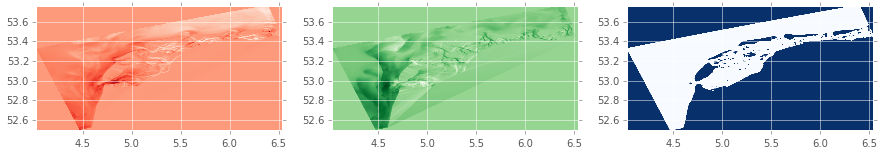

In [69]:
fig, axes = plt.subplots(1, 3 , figsize=(15,8))
axes[0].imshow(UV[...,0], cmap='Reds', origin='lower', extent=[ll[0], ur[0], ll[1], ur[1] ])
axes[1].imshow(UV[...,1], cmap='Greens', origin='lower', extent=[ll[0], ur[0], ll[1], ur[1]])
axes[2].imshow(isgrid, cmap='Blues', origin='lower', extent=[ll[0], ur[0], ll[1], ur[1]])

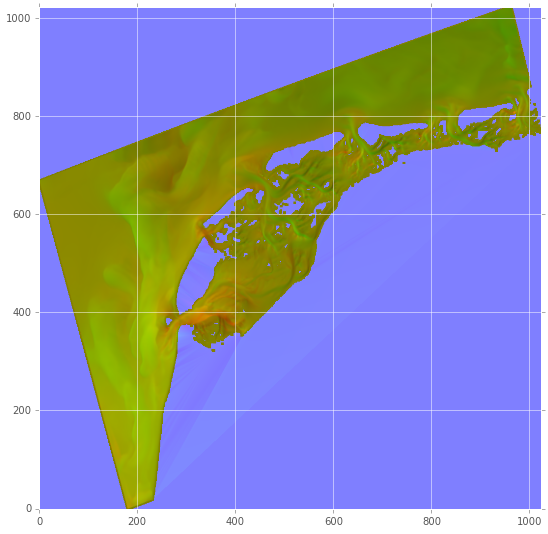

In [89]:
N_uv = matplotlib.colors.Normalize(-3, 3, clip=True)
r = N_uv(UV[...,0]).filled(0)
g = N_uv(UV[...,1]).filled(0)
b = isgrid
rgb = np.dstack([r,g,b])
plt.imsave('test.png', rgb)
plt.figure(figsize=(13,9))
plt.imshow(rgb, origin='top')
